In [1]:
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import torch

from models.ddpg import DDPG
from models.model import OUNoise
from env.AlphaEnv import AlphaEnv

/home/chenpeng/.conda/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '../data/processed/'
df_macro = pd.read_csv(file_path + 'macro_data.csv')
df_stock = pd.read_csv(file_path + 'stock_data.csv')
df_factor = pd.read_csv(file_path + 'factor_data.csv')
df_factor.iloc[:, 1:] = - df_factor.iloc[:, 1:]

train_size = int(len(df_stock) * 0.8)
df_macro_train, df_macro_test = df_macro[:train_size], df_macro[train_size:]
df_stock_train, df_stock_test = df_stock[:train_size], df_stock[train_size:]
df_factor_train, df_factor_test = df_factor[:train_size], df_factor[train_size:]

In [3]:
env = AlphaEnv(df_macro=df_macro_train, df_alpha=df_factor_train, df_price=df_stock_train)
hidden_size_list = [128, 128] 
agent = DDPG(env=env, hidden_size_list=hidden_size_list, max_memory_size=1e5, 
                actor_learning_rate=1e-3, critic_learning_rate=1e-3)
# noise = OUNoise(action_dim=2)

Initialize trade environment...
Aligning df_macro, df_price and df_alpha...
df_macro shape:  (2139, 109)
df_price shape:  (2139, 470)
df_alpha shape:  (2139, 470)


In [4]:
env.max_idx, train_size, env.look_forward

(2138, 2139, 1)

In [5]:
batch_size = 64
rewards = []
avg_rewards = []

for episode in range(20):
    state = env.reset()
    # noise.reset()
    episode_reward = 0
    
    for i in range(1, 5000):
        action = agent.get_action(state)
        # noise = np.clip(np.random.randn(2) , -0.1, 0.05)
        # action += noise
        action[0] += np.random.randn() * 0.05
        action[1] += np.clip(np.random.randn() * 0.05, -0.05, 0.05)
        action[0] = np.clip(action[0], 0.1, 20)
        # action[1] = np.clip(action[1], 0, 1)


        next_state, reward, terminated = env.step(action) 
        if not terminated:
            agent.memory.push(state, action, reward, next_state, terminated)
        
            state = next_state
            episode_reward += reward

        if len(agent.memory) > 1e3:
            agent.update(batch_size) 
            if i % 100 == 0:
                print('{}, {:>4d}, {}, {}: {:.7f}'.format(episode, i, env.current_idx, action.round(3), episode_reward / i))

        if terminated:
            print('terminated')
            break

    rewards.append(episode_reward)
    avg_rewards.append(np.mean(rewards[-10:]))

0, 1100, 1100, [ 0.303 -0.021]: -0.0001455
0, 1200, 1200, [20.    0.95]: 0.0000157
0, 1300, 1300, [20.     0.835]: 0.0005102
0, 1400, 1400, [20.     1.019]: 0.0004194
0, 1500, 1500, [20.    0.95]: 0.0003813
0, 1600, 1600, [20.     0.967]: 0.0003434
0, 1700, 1700, [20.     1.026]: 0.0004364
0, 1800, 1800, [20.    1.05]: 0.0003578
0, 1900, 1900, [20.    1.05]: 0.0004667
0, 2000, 2000, [20.     0.959]: 0.0004443
0, 2100, 2100, [20.     0.963]: 0.0003770
terminated
1,  100, 100, [20.    0.95]: -0.0055335
1,  200, 200, [20.    0.95]: -0.0043209
1,  300, 300, [20.     0.968]: -0.0027802
1,  400, 400, [20.     1.034]: -0.0019139
1,  500, 500, [20.    1.05]: -0.0023388
1,  600, 600, [20.     1.033]: -0.0020954
1,  700, 700, [20.    0.95]: -0.0016534
1,  800, 800, [20.     0.987]: -0.0009316
1,  900, 900, [20.    1.05]: -0.0007251
1, 1000, 1000, [20.     0.976]: -0.0005621
1, 1100, 1100, [20.    1.05]: -0.0003016
1, 1200, 1200, [20.     0.997]: -0.0001002
1, 1300, 1300, [20.    0.95]: 0.0004033

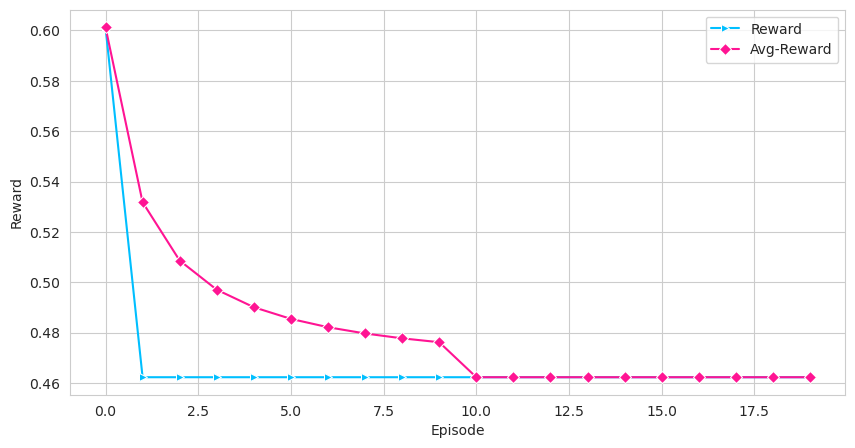

In [6]:
fig = plt.figure(figsize=(10,5))
sns.lineplot(rewards, marker='>', color='deepskyblue', label='Reward')
sns.lineplot(avg_rewards, marker='D', color='deeppink', label='Avg-Reward')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

### Out-of-sample performance

In [7]:
dates = list(set(df_macro['date']) & set(df_factor['date']) & set(df_stock['date']))
cols = list(set(df_factor.columns) & set(df_stock.columns))
data_macro_test = df_macro_test.loc[df_macro['date'].isin(dates)].set_index('date').values
data_factor_test = df_factor_test.loc[df_factor['date'].isin(dates), cols].set_index('date').values
data_stock_test = df_stock_test.loc[df_stock['date'].isin(dates), cols].set_index('date').values

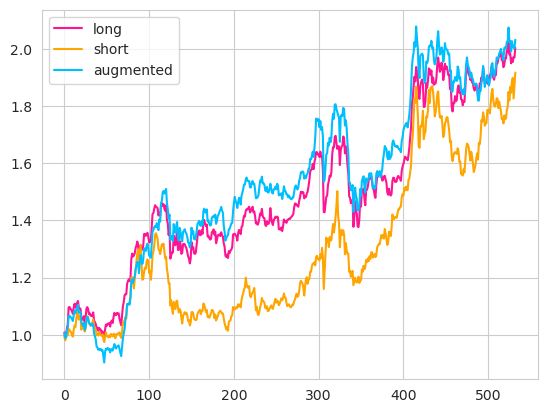

In [8]:
weight = np.zeros(data_stock_test.shape[1])
ret_list = []
ret_long_list = []
ret_short_list = []

# for i in range(len(data_macro_test) - 2):
#     state = data_macro_test[i].astype(float)
#     factor = data_factor_test[i].astype(float)
#     action = agent.get_action(state)
#     # print(action)
#     weight_new = env._to_weight(factor, action)
#     fee = np.linalg.norm(weight_new - weight, ord=1) * env.fee_ratio
#     ret_stock = data_stock_test[i+2] / data_stock_test[i+1] - 1
#     ret_net = ret_stock @ weight_new - fee
#     ret_list.append(ret_net)
#     weight = weight_new   

for i in range(len(data_macro_test) - 2):
    state = data_macro_test[i].astype(float)
    factor = data_factor_test[i].astype(float)
    action = agent.get_action(state)
    action[0] = np.clip(action[0], 0.1, 10)
    # print(action)
    
    w_start = np.ones_like(factor) / len(factor)
    w_a = env.weight_alpha(factor, action)  # 模型权重
    w_t, w_delta = env.weight_target(w_start, w_a)
    r = data_stock_test[i+2] / data_stock_test[i+1] - 1  # 股票收益率
    w_end, reward, fee = env.weight_end(r, w_t, w_delta)
    ret_list.append(reward)
    w_start = w_end 

    # 多头因子组合
    ind_max = np.argsort(factor)[-50:]
    ret_long = r[ind_max].mean()
    ret_long_list.append(ret_long)

    # 空头因子组合
    ind_min = np.argsort(factor)[:50]
    ret_short = r[ind_min].mean()
    ret_short_list.append(ret_short)

plt.plot(np.cumprod(1 + np.array(ret_long_list)), color='deeppink', label='long')
plt.plot(np.cumprod(1 + np.array(ret_short_list)), color='orange', label='short')
plt.plot(np.cumprod(1 + np.array(ret_list)), color='deepskyblue', label='augmented')
plt.legend()
plt.show()

In [9]:
sr_long = np.mean(ret_long_list) / np.std(ret_long_list)
sr_short = np.mean(ret_short_list) / np.std(ret_short_list)
sr_augmented = np.mean(ret_list) / np.std(ret_list)


print('SR-Long: ', sr_long.round(5))
print('SR-Short: ', sr_short.round(5))
print('SR-Augmented: ', sr_augmented.round(5))

SR-Long:  0.08931
SR-Short:  0.07709
SR-Augmented:  0.08909
